In [ ]:
from __future__ import print_function

#Numpy, pandas ans os
import numpy as np
import pandas as pd
import os
# matplotlib for displaying the output
import matplotlib.pyplot as plt

# Librosa for audio
import librosa


#parselmouth for audio
import parselmouth
from parselmouth.praat import call
from sklearn.decomposition import PCA
import statistics

#essentia

import essentia.standard
import essentia.streaming
from essentia.standard import *


#librairies for classification
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, cross_val_predict, KFold, cross_val_score
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, make_scorer, confusion_matrix

from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import ADASYN
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest

from sklearn.model_selection import GridSearchCV
import joblib
#for warning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category= ConvergenceWarning)

warnings.filterwarnings("ignore", category= UserWarning)
warnings.filterwarnings("ignore", category= RuntimeWarning)

Dataframe to match audio with emotion

In [20]:
parent_dir = "ravdess" #audio data folder
def prepare_datadf(parent_dir): # a function whose parameter is the audio folder
    df = pd.DataFrame(columns = ['audio', 'label']) #dataframe columns
    
    for  fichier_audio in os.listdir(parent_dir): # for each element in the audio folder
        folder_path = os.path.join(parent_dir, fichier_audio) # path of each item  in the audio folder
        
       
        
        if(os.path.isdir(folder_path)): 
            audios = os.listdir(folder_path) #content of each emotional file
            for i in audios:
                emotion = None
                if i.endswith('outNoise.wav'):
                    if i[7] == '1':     ##this specifies that we class neutral emotion against the others
                                    #1 represents the 7th column of the file name
                                    # This number varies for each emotion(ex calm = '2', fearfull = '6')
                        emotion = 1
                    
                    else:
                        emotion = 0
                    df = df.append(pd.DataFrame({'audio':[os.path.join(fichier_audio, i)], 'label':[emotion]}), 
                           ignore_index=True)  #adding values to the defined df:
                                            #the audio column will take the audios_path, 
                                            #and the emotion column will take the corresponding emotion, ie the name of the folder
    #Shuffling for randomness
    df = df.sample(frac=1.0).reset_index(drop=True)
    return df
datadf = prepare_datadf(parent_dir) #function call
display(datadf.head()) #dataframe display

	

,audio,label
0,fearfull/03-01-06-02-01-02-21_norm_outNoise.wav,0
1,fearfull/03-01-06-02-01-01-17_norm_outNoise.wav,0
2,fearfull/03-01-06-01-01-02-04_norm_outNoise.wav,0
3,surprised/03-01-08-02-02-01-19_norm_outNoise.wav,0
4,disgust/03-01-07-01-02-01-11_norm_outNoise.wav,0


Number of labels 1 and 0

In [21]:
array=datadf.values
audios=array[:,0]
emotions=array[:,1]
print(datadf.label.value_counts())

0    1149
1      96
Name: label, dtype: int64


Preprocessing

Function for framing and windowing the audio_files

In [22]:
def fram_window(audio_path):
    loader = essentia.standard.MonoLoader(filename= audio_path)

    # and then we actually perform the loading:
    audio = loader()

    w = Windowing(type = 'hann')
    spectrum = Spectrum() 
    #default parameter (hopsize and framesize)
    hopSize = 512
    frameSize = 1024 
    for frame in FrameGenerator(audio, frameSize=1024, hopSize=512, startFromZero=True):
        spect = spectrum(w(frame))
    return spect

function for features extraction:

In [23]:
def extract_features(audio_path):
    features = []
    
    
    #Load audios with the different libraries
      
    y,sr = librosa.load(audio_path)
    sound = parselmouth.Sound(audio_path)
    fs, sig = scipy.io.wavfile.read(audio_path) 
    
    pitch = call(sound, "To Pitch", 0.0, 75, 600)
    mean_pitch = call(pitch, "Get mean", 0, 0, "Hertz")
    
    spec =  fram_window(audio_path) 
    duration = librosa.get_duration(y= spec, sr=sr)
    energy = np.sum(spec ** 2) / np.float64(len(spec))
            
    lpc = librosa.core.lpc(spec,16)
            
    zcr = librosa.feature.zero_crossing_rate(spec)
               
    #gfccs = gfcc(sig= spec, fs=fs, num_ceps=13)    
    mfcc = librosa.feature.mfcc(y= spec, sr=sr, n_mfcc = 13)
        
    harmonicity = call(sound, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
    HNR = call(harmonicity, "Get mean", 0, 0)
                
    pointProcess = call(sound, "To PointProcess (periodic, cc)", 75, 500)
    localJitter = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    localabsoluteJitter = call(pointProcess, "Get jitter (local, absolute)", 0, 0, 0.0001, 0.02, 1.3)

    localShimmer =  call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    localdbShimmer = call([sound, pointProcess], "Get shimmer (local_dB)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
        
    formants = call(sound, "To Formant (burg)", 0.0, 5, 5500, 0.025, 100)
    numPoints = call(pointProcess, "Get number of points")

    f1_list = []
    f2_list = []
    f3_list = []
    f4_list = []
    
    # Measure formants only at glottal pulses
    for point in range(0, numPoints):
        point += 1
        t = call(pointProcess, "Get time from index", point)
        f1 = call(formants, "Get value at time", 1, t, 'Hertz', 'Linear')
        f2 = call(formants, "Get value at time", 2, t, 'Hertz', 'Linear')
        f3 = call(formants, "Get value at time", 3, t, 'Hertz', 'Linear')
        f4 = call(formants, "Get value at time", 4, t, 'Hertz', 'Linear')
        f1_list.append(f1)
        f2_list.append(f2)
        f3_list.append(f3)
        f4_list.append(f4)
        
    f1_list = [f1 for f1 in f1_list if str(f1) != 'nan']
    f2_list = [f2 for f2 in f2_list if str(f2) != 'nan']
    f3_list = [f3 for f3 in f3_list if str(f3) != 'nan']
    
    f4_list = [f4 for f4 in f4_list if str(f4) != 'nan']

    f1_mean = statistics.mean(f1_list)
    f2_mean = statistics.mean(f2_list)
    f3_mean = statistics.mean(f3_list)
    f4_mean = statistics.mean(f4_list)
    
    rapJitter = call(pointProcess, "Get jitter (rap)", 0, 0, 0.0001, 0.02, 1.3)
    ppq5Jitter = call(pointProcess, "Get jitter (ppq5)", 0, 0, 0.0001, 0.02, 1.3)
    ddpJitter = call(pointProcess, "Get jitter (ddp)", 0, 0, 0.0001, 0.02, 1.3)   
            
    apq3Shimmer = call([sound, pointProcess], "Get shimmer (apq3)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    aqpq5Shimmer = call([sound, pointProcess], "Get shimmer (apq5)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq11Shimmer =  call([sound, pointProcess], "Get shimmer (apq11)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    ddaShimmer = call([sound, pointProcess], "Get shimmer (dda)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    
    features.append(mean_pitch)
    features.append(duration)
    features.append(energy)
    features.append(np.mean(zcr))
    features.append(np.mean(lpc))
    
        
    features.append(np.mean(mfcc))
    
    #features.append(np.mean(gfccs))
    features.append(HNR)
    
    features.append(localJitter)
    features.append(np.mean(localabsoluteJitter))
    
    features.append(localShimmer)
    features.append(localdbShimmer)
    features.append(f1_mean)   
    features.append(f2_mean)
    features.append(f3_mean)
    features.append(f4_mean)
        
    features.append(rapJitter)
    features.append(ppq5Jitter)
    features.append(ddpJitter)
    
    features.append(apq3Shimmer)
    features.append(aqpq5Shimmer)
    features.append(apq11Shimmer)
    features.append(ddaShimmer)
        
    return features

Application of features extraction function on all audios

In [24]:
all_features = []
for audio_file in array[:,0]:
    if audio_file.endswith('.wav'):
        
        features = extract_features(parent_dir+'/'+audio_file)
        all_features.append(features)

In [25]:
print(len(all_features))

1245


Encode labels

In [26]:
encod = preprocessing.LabelEncoder()
emotions = array[:,1]
encod.fit(emotions)
list(encod.classes_)
labels=encod.transform(emotions)

Scale features

In [27]:
scaler = StandardScaler()
scaler.fit(all_features)
X_scaler = scaler.transform(all_features)

Oversampling

In [28]:
ada = ADASYN(sampling_strategy = 0.6)
X, y = ada.fit_sample(X_scaler, labels.ravel())
print("After OverSampling, counts of label '1': {}".format(sum(y==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y==0)))

After OverSampling, counts of label '1': 676
After OverSampling, counts of label '0': 1149


Process to select features after oversampling with ADASYN : the code first takes in a list the position of the features that are deleted, during the 1000 iterations, then uses a dataframe to count them. we notice that the features " [1, 2, 3, 4, 8, 13] " are deleted 699 times.

In [29]:
compt=0
df = pd.DataFrame(columns = ['iteration', 'X_removed'])
while compt < 1000:
    ada = ADASYN(sampling_strategy = 0.6)
    
    X, y = ada.fit_sample(X_scaler, labels.ravel())
    X = np.asarray(X)
    Kbest = SelectKBest(k="all")
    selec_features = Kbest.fit(X, y)
    alpha = 0.01
    #remove non_signifiant features selection
    X_selec = X[:,np.where(selec_features.pvalues_ < alpha)[0]]
    
    pos_removed = []    
    for i in range(len(X[0])):
   
        if X[0][i] not in X_selec[0]:
            #print(i)
            pos_removed.append(i)
            str_pos_removed = str(pos_removed)
    #print(pos_removed)
    
    compt = compt + 1
    df= df.append(pd.DataFrame({'iteration':[compt], 'X_removed':[str_pos_removed]}), ignore_index=True)
display(df.head())

print("Number of occurrences of features that are removed :")
df["X_removed"].value_counts()

,iteration,X_removed
0,1,"[1, 2, 3, 4, 8]"
1,2,"[1, 2, 3, 4, 8, 13]"
2,3,"[1, 2, 3, 4, 8, 13]"
3,4,"[1, 2, 3, 4, 8, 13]"
4,5,"[1, 2, 3, 4, 8]"


Number of occurrences of features that are removed :


[1, 2, 3, 4, 8, 13]    699
[1, 2, 3, 4, 8]        299
[1, 2, 3, 8, 13]         1
[1, 2, 3, 8]             1
Name: X_removed, dtype: int64

In [30]:
#manually feature selection
X_selected = []
for i in range(len(X)):
    #print(w[i][0])
    X_selected.append([X[i][0],  X[i][5], X[i][6], X[i][7],  X[i][9], X[i][10],
               X[i][11], X[i][12], X[i][14],  X[i][15], 
                X[i][16], X[i][17], X[i][18], X[i][19],  X[i][20], X[i][21]])

Split dataset to Train, Test and Val

In [31]:
#split train test
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=1)

print(len(X_train))
print(len(X_test))
print(len(X_val))

1168
365
292


Research of best parameters for all classifiers

In [32]:
classifiers = {
    'KNeighborsClassifier': KNeighborsClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'SVC': SVC(),
    'RandomForest' : RandomForestClassifier(),
    
    'LogisticRegression' : LogisticRegression(),
    'StochasticGradient' : SGDClassifier(),
    
    'XGboost': XGBClassifier()
}

params = {'StochasticGradient' : [{'loss': ['log', 'hinge', 'modified_huber', 'squared_hinge', 'perceptron'],
                'penalty': ['l1', 'l2', 'elasticnet'],
                'alpha': [10 ** x for x in range(-6, 1)],
                'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1]}],  
    
    
    
    'KNeighborsClassifier' : [{'n_neighbors': list(range(1,15))},
    {'metric': ['minkowski','euclidean','manhattan']}],
          
              
          
          
           'LogisticRegression': [{'C': [0.001,0.01,0.1,1,10,100],
                           'penalty' : [ 'l2']}] ,
    
          
           'DecisionTreeClassifier': [{'max_depth': [1,2,3,4,5,6,7,8,9,10]},
    {'criterion': ['gini', 'entropy']},
    {'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10]}],
          
       'SVC':[{'C': [0.001, 0.01, 0.1, 1, 10], 
    'gamma' : [0.001, 0.01, 0.1, 1], 
    'kernel': ['linear','rbf']}] ,
    
    'RandomForest':[{'max_depth': [1,2,3,4,5,6,7,8,9,10],
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10]}] ,
    
   
   
          
    'XGboost' :[{'max_depth': range(3,10,2),
                 'min_child_weight': range(1,6,2),
                 'gamma': [0.1,0.2,0.3,0.4],
                 'subsample': [0.5, 0.6, 0.7, 0.8, 0.9]
                }]
         }





class Result:
     def __init__(self,name, score, parameters):
         self.name = name
         self.score = score
         self.parameters = parameters
     def __repr__(self):
         return repr((self.name, self.score, self.parameters))

X_train_array = np.asarray(X_train)       
results = []
for key,value in classifiers.items():
    gd_sr = GridSearchCV(estimator=value,  
                     param_grid=params[key],
                     scoring='accuracy',
                     cv=5,
                     n_jobs=1,
                     iid=True)
    gd_sr.fit(X_train_array, y_train)  
    result=Result(key,gd_sr.best_score_,gd_sr.best_estimator_)
    results.append(result)   
    
    
    
results=sorted(results, key=lambda result: result.score, reverse=True) 

print (' the best result: \n')
print ('Classifier : ',results[0].name, 
       ' score %0.2f' %results[0].score, 
       ' with ',results[0].parameters,'\n')

print ('all results: \n')
for result in results:
    print ('Classifier : ',result.name, 
           ' score %0.2f' %result.score, 
           ' with ',result.parameters,'\n')

 the best result: 

Classifier :  SVC  score 0.98  with  SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False) 

all results: 

Classifier :  SVC  score 0.98  with  SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False) 

Classifier :  XGboost  score 0.94  with  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.2,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
             

LR : 


 accuracy_test: 0.7835616438356164 


 confusion_matrix_svm_test 
 [[187  31]
 [ 48  99]]

 precision_test : 0.7615384615384615

 recall_test : 0.673469387755102

 f1_score : 0.7148014440433211

               precision    recall  f1-score   support

           0       0.80      0.86      0.83       218
           1       0.76      0.67      0.71       147

    accuracy                           0.78       365
   macro avg       0.78      0.77      0.77       365
weighted avg       0.78      0.78      0.78       365



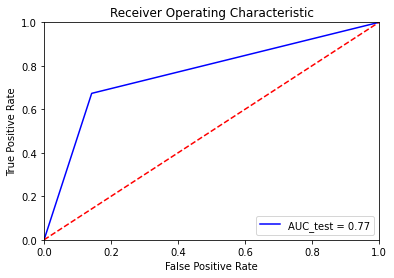

KNN : 


 accuracy_test: 0.947945205479452 


 confusion_matrix_svm_test 
 [[201  17]
 [  2 145]]

 precision_test : 0.8950617283950617

 recall_test : 0.9863945578231292

 f1_score : 0.9385113268608414

               precision    recall  f1-score   support

           0       0.99      0.92      0.95       218
           1       0.90      0.99      0.94       147

    accuracy                           0.95       365
   macro avg       0.94      0.95      0.95       365
weighted avg       0.95      0.95      0.95       365



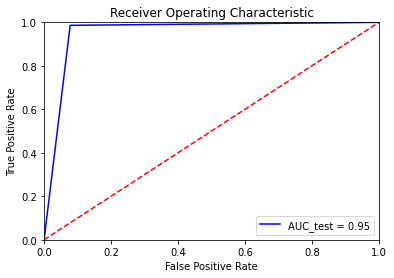

CART : 


 accuracy_test: 0.9342465753424658 


 confusion_matrix_svm_test 
 [[202  16]
 [  8 139]]

 precision_test : 0.896774193548387

 recall_test : 0.9455782312925171

 f1_score : 0.9205298013245032

               precision    recall  f1-score   support

           0       0.96      0.93      0.94       218
           1       0.90      0.95      0.92       147

    accuracy                           0.93       365
   macro avg       0.93      0.94      0.93       365
weighted avg       0.94      0.93      0.93       365



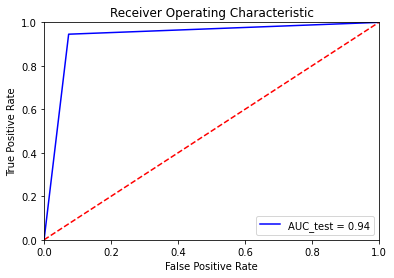

NB : 


 accuracy_test: 0.7589041095890411 


 confusion_matrix_svm_test 
 [[156  62]
 [ 26 121]]

 precision_test : 0.6612021857923497

 recall_test : 0.8231292517006803

 f1_score : 0.7333333333333334

               precision    recall  f1-score   support

           0       0.86      0.72      0.78       218
           1       0.66      0.82      0.73       147

    accuracy                           0.76       365
   macro avg       0.76      0.77      0.76       365
weighted avg       0.78      0.76      0.76       365



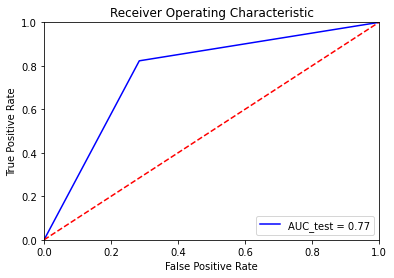

SVM : 


 accuracy_test: 0.9808219178082191 


 confusion_matrix_svm_test 
 [[216   2]
 [  5 142]]

 precision_test : 0.9861111111111112

 recall_test : 0.9659863945578231

 f1_score : 0.9759450171821307

               precision    recall  f1-score   support

           0       0.98      0.99      0.98       218
           1       0.99      0.97      0.98       147

    accuracy                           0.98       365
   macro avg       0.98      0.98      0.98       365
weighted avg       0.98      0.98      0.98       365



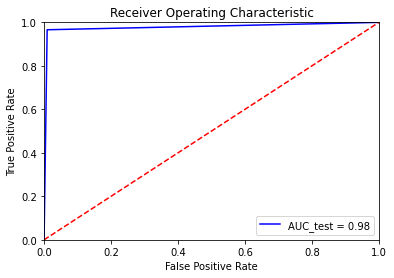

SGD : 


 accuracy_test: 0.7671232876712328 


 confusion_matrix_svm_test 
 [[178  40]
 [ 45 102]]

 precision_test : 0.7183098591549296

 recall_test : 0.6938775510204082

 f1_score : 0.7058823529411765

               precision    recall  f1-score   support

           0       0.80      0.82      0.81       218
           1       0.72      0.69      0.71       147

    accuracy                           0.77       365
   macro avg       0.76      0.76      0.76       365
weighted avg       0.77      0.77      0.77       365



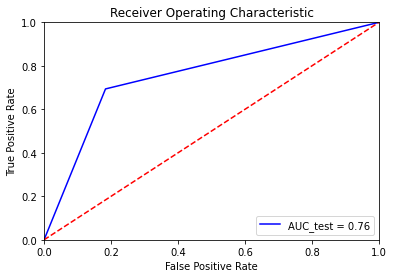

RF : 


 accuracy_test: 0.9726027397260274 


 confusion_matrix_svm_test 
 [[210   8]
 [  2 145]]

 precision_test : 0.9477124183006536

 recall_test : 0.9863945578231292

 f1_score : 0.9666666666666666

               precision    recall  f1-score   support

           0       0.99      0.96      0.98       218
           1       0.95      0.99      0.97       147

    accuracy                           0.97       365
   macro avg       0.97      0.97      0.97       365
weighted avg       0.97      0.97      0.97       365



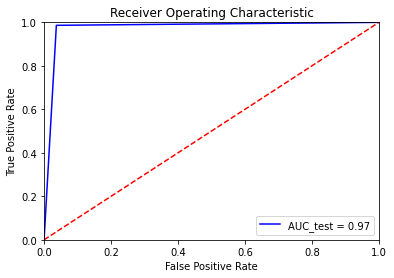

Xgboost : 


 accuracy_test: 0.958904109589041 


 confusion_matrix_svm_test 
 [[205  13]
 [  2 145]]

 precision_test : 0.9177215189873418

 recall_test : 0.9863945578231292

 f1_score : 0.9508196721311475

               precision    recall  f1-score   support

           0       0.99      0.94      0.96       218
           1       0.92      0.99      0.95       147

    accuracy                           0.96       365
   macro avg       0.95      0.96      0.96       365
weighted avg       0.96      0.96      0.96       365



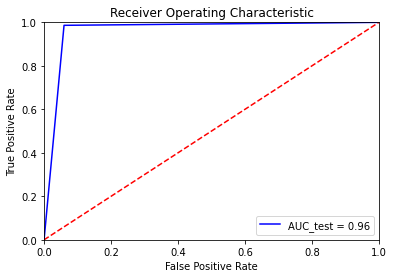

In [33]:
models = []

models.append(('LR', LogisticRegression(C = 10, penalty ='l2'))) #  name and function of classification
models.append(('KNN', KNeighborsClassifier(metric = 'minkowski', n_neighbors = 2)))
models.append(('CART', DecisionTreeClassifier(criterion = 'gini', min_samples_leaf = 1)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(C = 10, gamma = 1, kernel = 'rbf')))
models.append(('SGD',SGDClassifier(alpha = 0.01, l1_ratio = 0, loss = 'modified_huber', penalty = 'l1')))
models.append(('RF', RandomForestClassifier(criterion = 'gini', max_depth = 10, min_samples_leaf = 1)))
models.append(('Xgboost', XGBClassifier(gamma = 0.2, max_depth = 9, min_child_weight = 1, subsample = 0.6)))


for name,model in models:
    X_train_array = np.asarray(X_train)
    X_test_array = np.asarray(X_test)
    model.fit(X_train_array, y_train)
    result_test = model.predict(X_test_array)
    
    print(name, ':', '\n')
    
    print('\n accuracy_test:',accuracy_score(y_test, result_test),'\n')
    conf_test = confusion_matrix(y_test, result_test)
    
    print ('\n confusion_matrix_svm_test \n',conf_test)

    print ('\n precision_test :', precision_score(y_test, result_test))
    print('\n recall_test :', recall_score(y_test, result_test))
    print('\n f1_score :', f1_score(y_test, result_test))

    print('\n' ,classification_report(y_test, result_test))

     #auc_test

    fpr, tpr, threshold = metrics.roc_curve(y_test, result_test) 
    roc_auc_test = metrics.auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC_test = %0.2f' % roc_auc_test)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()




    filename = name+'_'+'neutral_ravdess_MODEL.pkl'
    joblib.dump(model, filename)

Validation

validation avec LR_neutral_ravdess_MODEL.pkl :

 accuracy_val: 0.7465753424657534 


 confusion_matrix_val 
 [[147  39]
 [ 35  71]]

 precision_val : 0.6454545454545455

 recall_val : 0.6698113207547169

 f1_score : 0.6574074074074074

               precision    recall  f1-score   support

           0       0.81      0.79      0.80       186
           1       0.65      0.67      0.66       106

    accuracy                           0.75       292
   macro avg       0.73      0.73      0.73       292
weighted avg       0.75      0.75      0.75       292



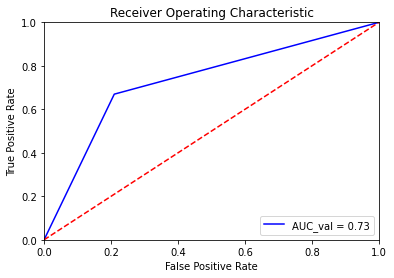

validation avec KNN_neutral_ravdess_MODEL.pkl :

 accuracy_val: 0.9143835616438356 


 confusion_matrix_val 
 [[162  24]
 [  1 105]]

 precision_val : 0.813953488372093

 recall_val : 0.9905660377358491

 f1_score : 0.8936170212765957

               precision    recall  f1-score   support

           0       0.99      0.87      0.93       186
           1       0.81      0.99      0.89       106

    accuracy                           0.91       292
   macro avg       0.90      0.93      0.91       292
weighted avg       0.93      0.91      0.92       292



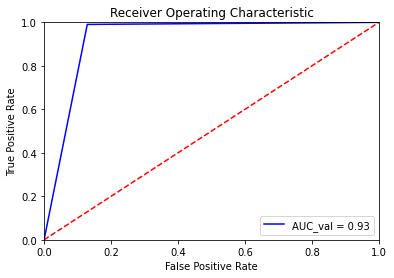

validation avec CART_neutral_ravdess_MODEL.pkl :

 accuracy_val: 0.9041095890410958 


 confusion_matrix_val 
 [[168  18]
 [ 10  96]]

 precision_val : 0.8421052631578947

 recall_val : 0.9056603773584906

 f1_score : 0.8727272727272727

               precision    recall  f1-score   support

           0       0.94      0.90      0.92       186
           1       0.84      0.91      0.87       106

    accuracy                           0.90       292
   macro avg       0.89      0.90      0.90       292
weighted avg       0.91      0.90      0.90       292



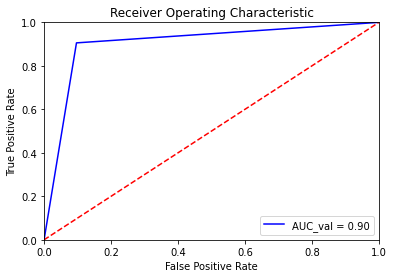

validation avec NB_neutral_ravdess_MODEL.pkl :

 accuracy_val: 0.702054794520548 


 confusion_matrix_val 
 [[118  68]
 [ 19  87]]

 precision_val : 0.5612903225806452

 recall_val : 0.8207547169811321

 f1_score : 0.6666666666666667

               precision    recall  f1-score   support

           0       0.86      0.63      0.73       186
           1       0.56      0.82      0.67       106

    accuracy                           0.70       292
   macro avg       0.71      0.73      0.70       292
weighted avg       0.75      0.70      0.71       292



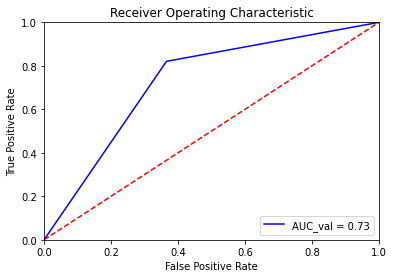

validation avec SVM_neutral_ravdess_MODEL.pkl :

 accuracy_val: 0.9794520547945206 


 confusion_matrix_val 
 [[183   3]
 [  3 103]]

 precision_val : 0.9716981132075472

 recall_val : 0.9716981132075472

 f1_score : 0.9716981132075472

               precision    recall  f1-score   support

           0       0.98      0.98      0.98       186
           1       0.97      0.97      0.97       106

    accuracy                           0.98       292
   macro avg       0.98      0.98      0.98       292
weighted avg       0.98      0.98      0.98       292



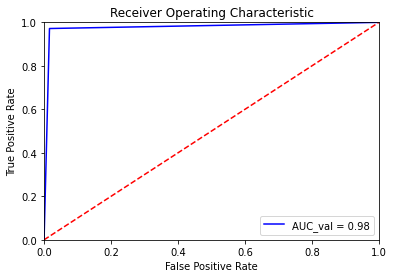

validation avec SGD_neutral_ravdess_MODEL.pkl :

 accuracy_val: 0.7431506849315068 


 confusion_matrix_val 
 [[143  43]
 [ 32  74]]

 precision_val : 0.6324786324786325

 recall_val : 0.6981132075471698

 f1_score : 0.663677130044843

               precision    recall  f1-score   support

           0       0.82      0.77      0.79       186
           1       0.63      0.70      0.66       106

    accuracy                           0.74       292
   macro avg       0.72      0.73      0.73       292
weighted avg       0.75      0.74      0.75       292



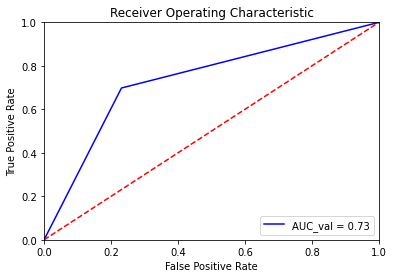

validation avec RF_neutral_ravdess_MODEL.pkl :

 accuracy_val: 0.934931506849315 


 confusion_matrix_val 
 [[172  14]
 [  5 101]]

 precision_val : 0.8782608695652174

 recall_val : 0.9528301886792453

 f1_score : 0.9140271493212669

               precision    recall  f1-score   support

           0       0.97      0.92      0.95       186
           1       0.88      0.95      0.91       106

    accuracy                           0.93       292
   macro avg       0.93      0.94      0.93       292
weighted avg       0.94      0.93      0.94       292



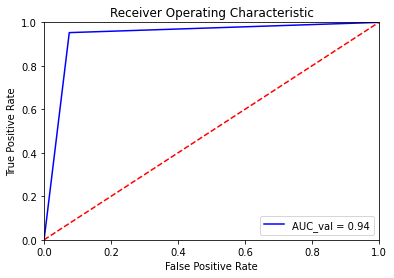

validation avec Xgboost_neutral_ravdess_MODEL.pkl :

 accuracy_val: 0.9315068493150684 


 confusion_matrix_val 
 [[168  18]
 [  2 104]]

 precision_val : 0.8524590163934426

 recall_val : 0.9811320754716981

 f1_score : 0.912280701754386

               precision    recall  f1-score   support

           0       0.99      0.90      0.94       186
           1       0.85      0.98      0.91       106

    accuracy                           0.93       292
   macro avg       0.92      0.94      0.93       292
weighted avg       0.94      0.93      0.93       292



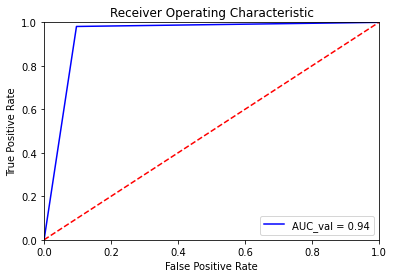

In [34]:
#testing sauvegarded model on Val dataset
loaded = ['LR_neutral_ravdess_MODEL.pkl', 'KNN_neutral_ravdess_MODEL.pkl', 'CART_neutral_ravdess_MODEL.pkl', 
          'NB_neutral_ravdess_MODEL.pkl','SVM_neutral_ravdess_MODEL.pkl', 'SGD_neutral_ravdess_MODEL.pkl',
          'RF_neutral_ravdess_MODEL.pkl', 'Xgboost_neutral_ravdess_MODEL.pkl']


for filename in loaded:
    loaded_model = joblib.load(filename)
    X_val_array =  np.asarray(X_val)
    result_val = loaded_model.predict(X_val_array)

    print('validation avec' ,filename , ':')
    
    print('\n accuracy_val:',accuracy_score(y_val, result_val),'\n')
    conf_val = confusion_matrix(y_val, result_val)
    print ('\n confusion_matrix_val \n',conf_val)

    print ('\n precision_val :', precision_score(y_val, result_val))
    print('\n recall_val :', recall_score(y_val, result_val))
    print('\n f1_score :', f1_score(y_val, result_val))

    print('\n' ,classification_report(y_val, result_val))

    


    #auc_val
    fpr, tpr, threshold = metrics.roc_curve(y_val, result_val) 
    roc_auc_val = metrics.auc(fpr, tpr)
    
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC_val = %0.2f' % roc_auc_val)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()